In [1]:
import os
os.chdir('C:\\Users\\Administrator\\Downloads\\ML Lab')

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step
from timeseires.utils.univariate_single_step import univariate_single_step
from timeseires.utils.CosineAnnealingLRS import CosineAnnealingLRS
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate, Dense
from tensorflow.keras.regularizers import l2
import glob
import h5py
import matplotlib.pyplot as plt
from keras.callbacks import Callback

In [3]:
#lookback = 24
model = None
start_epoch = 0
time_steps=24
num_features=21

In [4]:
def create_lstm():
    input_data = Input(shape=(time_steps, num_features))
    lstm_layer1 = LSTM(8, return_sequences=True)(input_data)
    lstm_layer2 = LSTM(20)(lstm_layer1)
    x = Flatten()(lstm_layer2)
    output_data = Dense(1)(x)
    model = Model(input_data, output_data)
    return model

In [5]:
model1 = create_lstm()
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 21)]          0         
                                                                 
 lstm (LSTM)                 (None, 24, 8)             960       
                                                                 
 lstm_1 (LSTM)               (None, 20)                2320      
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 3,301
Trainable params: 3,301
Non-trainable params: 0
_________________________________________________________________


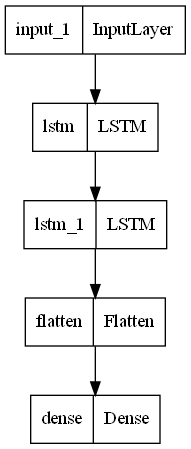

In [6]:
tensorflow.keras.utils.plot_model(model1 )

In [7]:
checkpoints = r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab10\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab10'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"\history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"\history.json"])

In [8]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [9]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model =create_lstm()
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [10]:
import os
path_dataset ='C:\\Users\\Administrator\\Downloads\\ML Lab\\AEP_hourly\\processed'
path_tr = os.path.join(path_dataset, 'AEP_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values
path_v = os.path.join(path_dataset, 'AEP_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 
path_te = os.path.join(path_dataset, 'AEP_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 

path_scaler = os.path.join(path_dataset, 'AEP_Scaler.pkl')
scaler         = pickle.load(open(path_scaler, 'rb'))

train_set.shape, validation_set.shape, test_set.shape

C:\Users\Administrator\anaconda3\envs\Time1\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


((84907, 21), (24259, 21), (12130, 21))

In [11]:
time_steps=24
num_features=21

In [12]:
start = time.time()
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=1)
validation_X, validation_y = univariate_multi_step(validation_set, time_steps, target_col=0,target_len=1)
test_X, test_y = univariate_multi_step(test_set, time_steps, target_col=0,target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 0.536205530166626 sec


In [13]:
epochs = 60
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,verbose = verbose)

Epoch 1/60
2652/2653 [============================>.] - ETA: 0s - loss: 0.0417 - mae: 0.0417 - mape: 529.5672
Epoch 1: val_loss improved from inf to 0.02112, saving model to C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab10\E1-cp-0001-loss0.02.h5
2653/2653 [==============================] - 65s 22ms/step - loss: 0.0417 - mae: 0.0417 - mape: 529.4561 - val_loss: 0.0211 - val_mae: 0.0211 - val_mape: 9.7241
Epoch 2/60
2651/2653 [============================>.] - ETA: 0s - loss: 0.0166 - mae: 0.0166 - mape: 220.2914
Epoch 2: val_loss improved from 0.02112 to 0.01255, saving model to C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab10\E1-cp-0002-loss0.01.h5
2653/2653 [==============================] - 58s 22ms/step - loss: 0.0166 - mae: 0.0166 - mape: 220.1644 - val_loss: 0.0126 - val_mae: 0.0126 - val_mape: 5.5249
Epoch 3/60
2652/2653 [============================>.] - ETA: 0s - loss: 0.0122 - mae: 0.0122 - mape: 193.7269
Epoch 3: val_loss improved from 0.01255 to

In [17]:

model = load_model(r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab10\E1-cp-0033-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 3s 5ms/step
Mean Absolute Error (MAE): 96.74
Median Absolute Error (MedAE): 75.86
Mean Squared Error (MSE): 16711.97
Root Mean Squared Error (RMSE): 129.27
Mean Absolute Percentage Error (MAPE): 0.66 %
Median Absolute Percentage Error (MDAPE): 0.53 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)


In [18]:
checkpoints = r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab10\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model=r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab10\E1-cp-0033-loss0.01.h5'
start_epoch= 34

In [19]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=24, num_features=21, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab10\E1-cp-0033-loss0.01.h5...
[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 9.999999747378752e-05


In [20]:
epochs = 10
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/10
2653/2653 [==============================] - ETA: 0s - loss: 0.0058 - mae: 0.0058 - mape: 14.8268
Epoch 1: val_loss improved from inf to 0.00590, saving model to C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab10\E2-cp-0001-loss0.01.h5
2653/2653 [==============================] - 58s 21ms/step - loss: 0.0058 - mae: 0.0058 - mape: 14.8268 - val_loss: 0.0059 - val_mae: 0.0059 - val_mape: 2.4532
Epoch 2/10
2653/2653 [==============================] - ETA: 0s - loss: 0.0058 - mae: 0.0058 - mape: 30.0224
Epoch 2: val_loss did not improve from 0.00590
2653/2653 [==============================] - 60s 23ms/step - loss: 0.0058 - mae: 0.0058 - mape: 30.0224 - val_loss: 0.0060 - val_mae: 0.0060 - val_mape: 2.4553
Epoch 3/10
2652/2653 [============================>.] - ETA: 0s - loss: 0.0058 - mae: 0.0058 - mape: 14.1057
Epoch 3: val_loss did not improve from 0.00590
2653/2653 [==============================] - 58s 22ms/step - loss: 0.0058 - mae: 0.0058 - mape: 14.1030 - va

In [19]:

model = load_model(r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab8\E2-cp-0008-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 103.3
Median Absolute Error (MedAE): 82.18
Mean Squared Error (MSE): 18772.44
Root Mean Squared Error (RMSE): 137.01
Mean Absolute Percentage Error (MAPE): 0.71 %
Median Absolute Percentage Error (MDAPE): 0.57 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)
